In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [16]:
# Let's start with a really simple evaluation
x = tf.constant(3)
f = x**2

tf.Session().run(f)

9

NOTE: `tf.constant()` isn't meant for large arrays, it will be stored in memory multiple times, [according to this stackoverflow post at least](https://stackoverflow.com/questions/41150741/in-tensorflow-what-is-the-difference-between-a-constant-and-a-non-trainable-var?rq=1) 

For taking in data, use `tf.placeholder()` instead.

In [17]:
# Here's an example of how to use tf.placeholder() 
c = tf.constant(3.0)
x = tf.placeholder('float32', (None, None, 3))  # tf expects x to be of shape (unknown, unknown, 3)
f = c*x**2

# let's make some fake data to feed in
some_big_array = np.random.rand(1000, 1000, 3)

# Let's feed our fake data in as `x` and request that the quantity f be returned
tf_answer = tf.Session().run(fetches=[f], feed_dict={x: some_big_array})

# Let's check that the result matches numpy's answer
np_answer = 3*some_big_array**2
norm = np.linalg.norm  # Frobenius distance
print("relative error = %.3g" % (norm(tf_answer - np_answer)/norm(some_big_array)))

relative error = 1.3e-07


### Now let's try something ML-ish (i.e. let's use gradient descent for some silly thing): 
Let's make the weight, `c`, "trainable" and use TensorFlow find the vector $\vec c$ such that, for some given pair $(x,y)$, we have $f(x) = c_3x^2 + c_2*x**2 + c_1*x + c_0 \approx y$.  
I.e. let's use TensorFlow to fit a cubic polynomial to some random data.

Since we want `c` to trainable, we'll want to use `tf.variable()` instead of `tf.contant()` -- also, note that since we're training `c`, we need to start with some initial guess.

In [18]:
def cubic_fit(x_train, y_train, batch_size, epochs, learning_rate):
    # pick randomize the initial guess and set up inputs
    c = tf.Variable(tf.truncated_normal([4, 1]))
    x = tf.placeholder(tf.float32, (batch_size,))
    y = tf.placeholder(tf.float32, (batch_size,))
    X = tf.stack([tf.ones(tf.shape(x)), x, x**2, x**3], axis=1)
    
    # compute predictions and loss
    y_hat = tf.squeeze(tf.matmul(X, c))  # `tf.squeeze` is similar to `np.ravel`
    loss = tf.reduce_sum((y - y_hat)**2)/batch_size

    # To train: specify an optimization scheme and add it to the `fetches`
    # all "trainable" variables will be trained (here that's just `c`)
    update_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  # initialize weights (i.e. initial guess for c)
        for epoch in range(epochs):
            # shuffle
            permutation = np.random.permutation(len(x_train))
            x_train, y_train = x_train[permutation], y_train[permutation]
            
            # train for an epoch
            for step in range(num_samples//batch_size):
                x_batch = x_train[step*batch_size: (step + 1)*batch_size]
                y_batch = y_train[step*batch_size: (step + 1)*batch_size]

                y_hat_, loss_, _ = sess.run(fetches=[y_hat, loss, update_step], 
                                                    feed_dict={x: x_batch, y: y_batch})
            
            print("epoch: %s | loss = %s" %(epoch, loss_))
    return x_batch, y_hat_
        

In [23]:
# let's make some fake data that's could reasonably be approximated by a cubic
npr = np.random
num_samples = 1024
cubic = np.poly1d(1 + npr.randint(-10, 10, (4,)))      # a random cubic
x_train = np.linspace(np.roots(cubic).real.min()-1,np.roots(cubic).real.max()+1,num_samples)                        # training data
y_train = (cubic(x_train) + npr.rand(num_samples)/10)  # training ground truth

In [24]:
xb, yh = cubic_fit(x_train, y_train, batch_size=32, epochs=10, learning_rate = 0.1)

epoch: 0 | loss = 0.08343517
epoch: 1 | loss = 0.0025502238
epoch: 2 | loss = 0.0011012359
epoch: 3 | loss = 0.00067876466
epoch: 4 | loss = 0.00090959313
epoch: 5 | loss = 0.00062046933
epoch: 6 | loss = 0.00080390926
epoch: 7 | loss = 0.0007886536
epoch: 8 | loss = 0.0010220048
epoch: 9 | loss = 0.0012542988


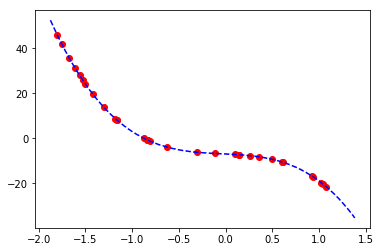

In [25]:
xb, yh = zip(*sorted(zip(xb,yh)))
plt.plot(xb, yh, 'ro', x_train, y_train, 'b--')
plt.show()